#retriving from git

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2452, done.
remote: Total 2452 (delta 0), reused 0 (delta 0), pack-reused 2452
Receiving objects: 100% (2452/2452), 8.18 MiB | 37.73 MiB/s, done.
Resolving deltas: 100% (1538/1538), done.


In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 676 kB 42.7 MB/s 
     |████████████████████████████████| 1.8 MB 46.4 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 157 kB 11.7 MB/s 
     |████████████████████████████████| 181 kB 66.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 51.2 MB/s 
     |████████████████████████████████| 157 kB 48.0 MB/s 
     |████████████████████████████████| 157 kB 51.8 MB/s 
     |████████████████████████████████| 157 kB 11.6 MB/s 
     |████████████████████████████████| 156 kB 54.8 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=bf949c2382d4b19441b4deb1b447bed03b1d370fbf642fe291b893f2ec23862f
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Creat

In [ ]:
!bash ./datasets/download_cyclegan_dataset.sh ukiyoe2photo

Specified [ukiyoe2photo]
for details.

--2022-08-25 11:13:18--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/ukiyoe2photo.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 292946532 (279M) [application/zip]
Saving to: ‘./datasets/ukiyoe2photo.zip’

           ./datase  21%[===>                ]  59.39M  1008KB/s    eta 3m 25s 

In [ ]:
!bash ./scripts/download_cyclegan_model.sh style_ukiyoe

In [ ]:
model_path = '/content/pytorch-CycleGAN-and-pix2pix/checkpoints/style_ukiyoe_pretrained/latest_net_G.pth'

In [ ]:
data_dir = '/content/ukiyoe/ukiyoe-cycle-gan/ukiyoe2photo'
os.listdir(data_dir)

['trainA', 'trainB', 'testA', 'testB']

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from PIL import Image
from tqdm.notebook import tqdm
import shutil

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.listdir(data_dir)

['trainA', 'trainB', 'testA', 'testB']

In [ ]:
len(os.listdir(os.path.join(data_dir, 'trainA'))) ,len(os.listdir(os.path.join(data_dir, 'trainB')))

(562, 2306)

In [ ]:
len(os.listdir(os.path.join(data_dir, 'testA'))), len(os.listdir(os.path.join(data_dir, 'testB')))

(0, 751)

In [ ]:
os.listdir(os.path.join(data_dir, 'trainA'))[41]

'00752.jpg'

In [ ]:
img = os.path.join(data_dir, 'trainA/00482.jpg')
photo = os.path.join(data_dir, 'trainB/2015-06-01 04:55:15.jpg')

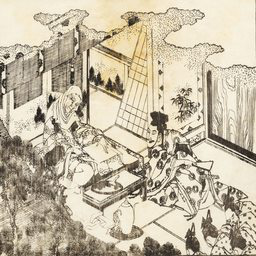

In [ ]:
Image.open(img)

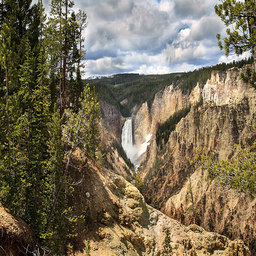

In [ ]:
Image.open(photo)

In [ ]:
seed = 142

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data_dir, test=False, tfms=None):
    super(ImageDataset, self).__init__()
    if test:
      ukiyoe_dir = os.path.join(data_dir, 'testA')
      photo_dir = os.path.join(data_dir, 'testB')
    else:
      ukiyoe_dir = os.path.join(data_dir, 'trainA')
      photo_dir = os.path.join(data_dir, 'trainB')

    self.files_ukiyoe = [os.path.join(ukiyoe_dir, name) for name in sorted(os.listdir(ukiyoe_dir))]
    self.files_photo = [os.path.join(photo_dir, name) for name in sorted(os.listdir(photo_dir))]

    self.tfms = tfms

  def __len__(self):
    return len(self.files_ukiyoe)

  def __getitem__(self, index):
    random_index = np.random.randint(0, len(self.files_ukiyoe))
    file_ukiyoe = self.files_ukiyoe[index]
    file_photo = self.files_photo[random_index]

    file_ukiyoe = Image.open(file_ukiyoe)
    file_photo = Image.open(file_photo)

    if self.tfms is not None:
      file_ukiyoe = self.tfms(file_ukiyoe)
      file_photo = self.tfms(file_photo)
    if file_ukiyoe.shape[0] == 0

    return file_ukiyoe, file_photo

In [ ]:
stats = ((0.5), (0.5))
train_tfms = tt.Compose([tt.Resize([256, 256]),
                         tt.RandomHorizontalFlip(p=0.5),
                         tt.RandomVerticalFlip(p=0.2),
                         tt.CenterCrop(256),
                         tt.ToTensor(),
                         tt.Normalize(*stats),
                         tt.RandomErasing(p=0.2)])
test_tfms = tt.Compose([tt.Resize([256, 256]), tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds = ImageDataset(data_dir, test=False, tfms=train_tfms)
test_ds = ImageDataset(data_dir, test=True, tfms=test_tfms)

In [ ]:
for img, photo in train_ds:
  pass

In [ ]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img, mean=0.5, std=0.5):
  return img * std + mean

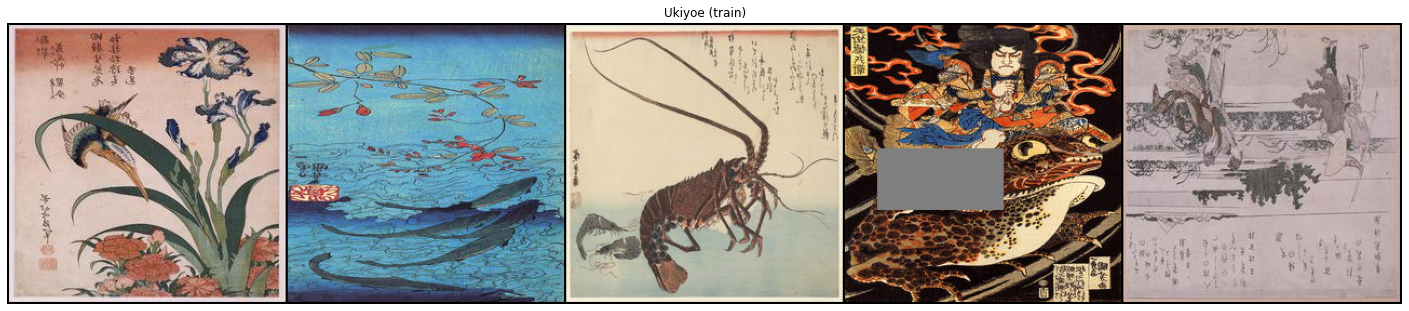

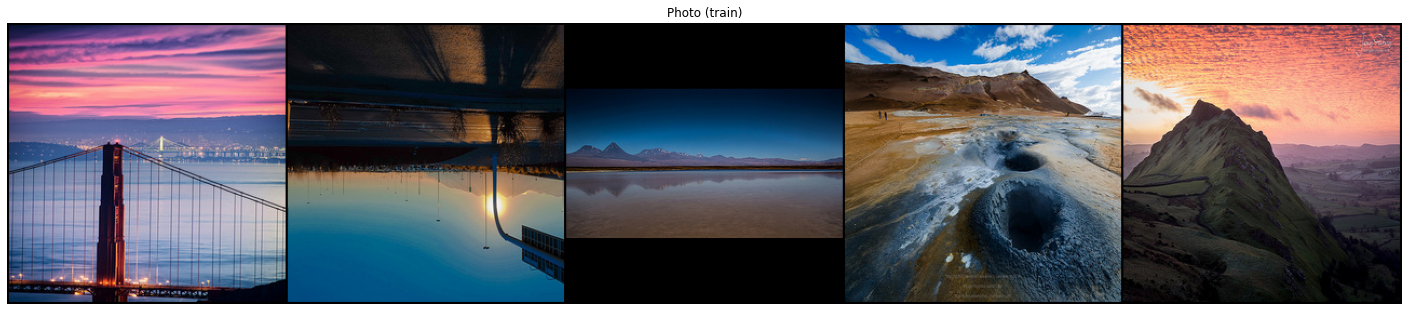

In [ ]:
for b in train_dl:
  ukiyoes, photos = b
  plt.figure(figsize=(25, 10))
  plt.imshow(make_grid(denorm(ukiyoes), nrow=5).permute(1,2,0))
  plt.title('Ukiyoe (train)')
  plt.axis('off')
  plt.figure(figsize=(25, 10))
  plt.imshow(make_grid(denorm(photos), nrow=5).permute(1,2,0))
  plt.title('Photo (train)')
  plt.axis('off')
  break

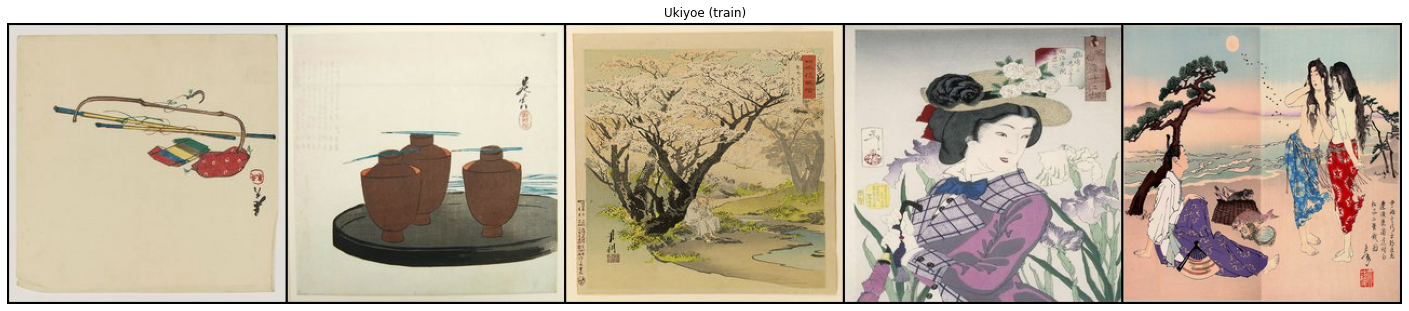

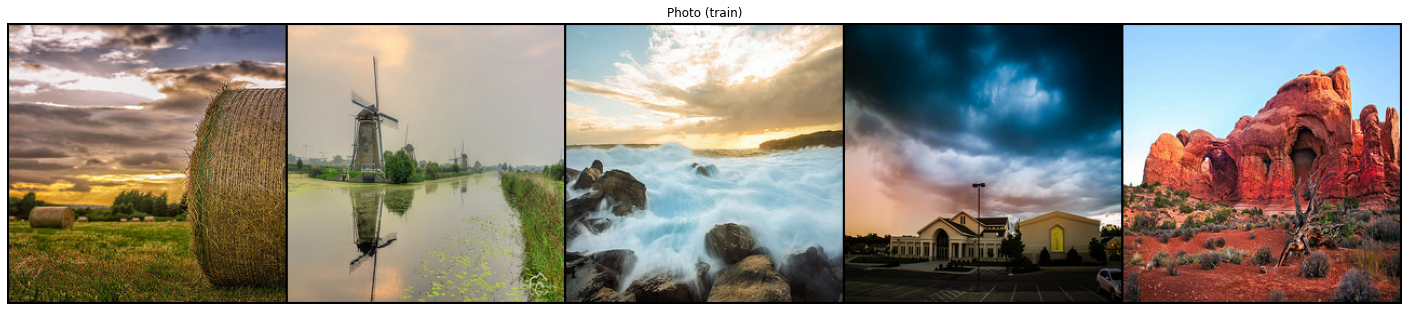

In [ ]:
for b in test_dl:
  ukiyoes, photos = b
  plt.figure(figsize=(25, 10))
  plt.imshow(make_grid(denorm(ukiyoes), nrow=5).permute(1,2,0))
  plt.title('Ukiyoe (train)')
  plt.axis('off')
  plt.figure(figsize=(25, 10))
  plt.imshow(make_grid(denorm(photos), nrow=5).permute(1,2,0))
  plt.title('Photo (train)')
  plt.axis('off')
  break

# Auxiliary blocks: `ConvBlock` and `ResidualBlock`

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels,
               kernel_size=3, stride=1, padding=0,
               transpose=False, leaky=True, dropout=False, normalize=True):
    super(ConvBlock, self).__init__()

    self.block = []

    if transpose:
      self.block += [nn.ConvTranspose2d(in_channels, out_channels,
                                        kernel_size=kernel_size,
                                        stride=stride, padding=padding,
                                        output_padding=1)]
    else:
      self.block += [nn.Conv2d(in_channels, out_channels,
                               kernel_size=kernel_size, stride=stride,
                               padding=padding, padding_mode='reflect')]

    if normalize:
      self.block += [nn.InstanceNorm2d(num_features=out_channels)]

    if dropout:
      self.block += [nn.Dropout(p=0.5, inplace=True)]

    if leaky:
      self.block += [nn.LeakyReLU(negative_slope=0.2, inplace=True)]
    else:
      self.block += [nn.ReLU(inplace=True)]

    self.block = nn.Sequential(*self.block)

  def forward(self, x):
    return self.block(x)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()

    self.block = nn.Sequential(
        nn.ReflectionPad2d(1),
        ConvBlock(in_channels=channels, out_channels=channels, kernel_size=3, leaky=False, dropout=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3),
        nn.InstanceNorm2d(num_features=channels),
        nn.ReLU()
    )

  def forward(self, x):
    return self.block(x) + x

# Models

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels: int=3, out_channels: int=3,
               num_residual_blocks: int=9):
    super(Generator, self).__init__()
    '''Encoder'''
    # initial layer: 3 x 256 x 256 -> 64 x 256 x 256
    self.initial = nn.Sequential(
        nn.ReflectionPad2d(in_channels),
        ConvBlock(in_channels, 64, kernel_size=2*in_channels+1, leaky=False)
    )

    # downsampling: 64 x 256 x 256 -> 128 x 128 x 128 -> 256 x 64 x 64 -> 512 x 32 x 32
    self.down = nn.Sequential(
        ConvBlock(64, 128, kernel_size=3, stride=2, padding=1, leaky=False),
        ConvBlock(128, 256, kernel_size=3, stride=2, padding=1, leaky=False),
        ConvBlock(256, 512, kernel_size=3, stride=2, padding=1, dropout=True)
    )

    '''Transformer'''
    # resnet: 512 x 32 x 32 -> 512 x 32 x 32
    self.transform = [ResidualBlock(512) for _ in range(num_residual_blocks)]
    self.transform = nn.Sequential(*self.transform)

    '''Decoder'''
    # upsampling: 512 x 32 x 32 -> 256 x 64 x 64 -> 128 x 128 x 128 -> 64 x 256 x 256
    self.up = nn.Sequential(
        ConvBlock(512, 256, kernel_size=3, stride=2, padding=1, transpose=True, leaky=False),
        ConvBlock(256, 128, kernel_size=3, stride=2, padding=1, transpose=True, leaky=False),
        ConvBlock(128, 64, kernel_size=3, stride=2, padding=1, transpose=True, dropout=True)
    )

    # out layer: 64 x 256 x 256 -> 3 x 256 x 256
    self.out = nn.Sequential(
        nn.ReflectionPad2d(out_channels),
        nn.Conv2d(64, out_channels, kernel_size=2*out_channels+1),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.down(self.initial(x))
    x = self.transform(x)
    x = self.out(self.up(x))
    return x

# Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels: int=3):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        # 3 x 256 x 256 -> 64 x 128 x 128
        ConvBlock(in_channels, 64, kernel_size=4, stride=2, padding=1),

        # 64 x 128 x 128 -> 128 x 64 x 64
        ConvBlock(64, 128, kernel_size=4, stride=2, padding=1),

        # 128 x 64 x 64 -> 256 x 32 x 32
        ConvBlock(128, 256, kernel_size=4, stride=2, padding=1),

        # 256 x 32 x 32 -> 512 x 31 x 31
        ConvBlock(256, 512, kernel_size=4, stride=1, padding=1),

        # 512 x 31 x 31 -> 1 x 30 x 30
        ConvBlock(512, 1, kernel_size=4, stride=1, padding=1, dropout=True)
    )

  def forward(self, x):
    return self.model(x)

# Training tools

Model initialization

In [ ]:
generator_ukiyoe2photo = Generator().to(device, non_blocking=True)
generator_photo2ukiyoe = Generator().to(device, non_blocking=True)

discriminator_ukiyoe = Discriminator().to(device, non_blocking=True)
discriminator_photo = Discriminator().to(device, non_blocking=True)

Lossees


In [ ]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

Optimizers

In [ ]:
lr = 2e-4
b1 = 0.5
b2 = 0.999

optim_generators = torch.optim.Adam(
    list(generator_ukiyoe2photo.parameters()) + list(generator_photo2ukiyoe.parameters()),
    lr=lr, betas=(b1, b2)
)

optim_discriminators = torch.optim.Adam(
    list(discriminator_ukiyoe.parameters()) + list(discriminator_photo.parameters()),
    lr=lr, betas=(b1, b2)
)

Learning rate schedulers

In [ ]:
num_epochs = 80
decay_epoch = 25

lr_sched_step = lambda epoch: 1 - max(0, epoch - decay_epoch) / (num_epochs - decay_epoch)

lr_sched_generators = torch.optim.lr_scheduler.LambdaLR(optim_generators, lr_sched_step)
lr_sched_discriminators = torch.optim.lr_scheduler.LambdaLR(optim_discriminators, lr_sched_step)

# Auxiliary tools

In [ ]:
def get_lr(optim):
  for param_group in optim.param_groups:
    return param_group["lr"]

In [ ]:
def update_req_grad(models, grad=True):
  for model in models:
    for param in model.parameters():
      param.requires_grad = grad

In [ ]:
class History():
  def __init__(self):
    self.gen_losses = []
    self.discr_losses = []
    self.lrs = []

  def update_losses(self, gen_loss, discr_loss):
    self.gen_losses.append(gen_loss)
    self.discr_losses.append(discr_loss)

  def update_lrs(self, lr):
    self.lrs.append(lr)

  def plot_losses(self, title='Losses'):
    fig = plt.figure(figsize=(20,9))
    plt.title(title)
    plt.plot(self.gen_losses, 'o-', color='r',
             linewidth=2, markersize=3, label='Generators Loss')
    plt.plot(self.discr_losses, 'o-', color='b',
             linewidth=2, markersize=3, label='Discriminators Loss')
    plt.legend(loc='best')
    plt.xlabel('Epoch N.')
    plt.ylabel('Loss score')
    plt.grid(True)
    plt.show();

  def plot_lrs(self):
    fig = plt.figure(figsize=(20, 9))
    plt.title('Learning rates')
    plt.plot(self.lrs)
    plt.xlabel('Batch N.')
    plt.ylabel('Learning rate')
    plt.grid(True)
    plt.show();

In [ ]:
class Buffer():
  def __init__(self, max_images=50):

    self.max_images = max_images
    self.images = []

  def update(self, images):
    images = images.detach().cpu().data.numpy()
    for image in images:
      if len(self.images) < self.max_images:
        self.images.append(image)
      else:
        if np.random.rand() > 0.5:
          index = np.random.randint(0, len(self.images))
          self.images[index] = image

  def sample(self, num_images):
    samples = np.array([self.images[np.random.randint(0, len(self.images))] for _ in range(num_images)])
    return torch.tensor(samples)



In [ ]:
def fit(num_epochs, generator_1, generator_2,
                 discriminator_1, discriminator_2,
                 buffer_1, buffer_2,
                 optim_generators, optim_discriminators,
                 lr_sched_generators, lr_sched_discriminators,
                 history, train_dl, test_dl=None):
  for epoch in range(num_epochs):
    avg_generator_loss = 0
    avg_discriminator_loss = 0

    for i, (real_ukiyoe, real_photo) in enumerate(tqdm(train_dl, leave=False, total=len(train_dl)):
      real_ukiyoe, real_photo = real_ukiyoe.to(device), real_photo.to(device)
      '''Train generators'''
      # switching models parameters so that only generators are trained
      update_req_grad([generator_ukiyoe2photo, generator_photo2ukiyoe], grad=True)
      update_req_grad([discriminator_ukiyoe, discriminator_photo], grad=False)

      # zero parameters for gradients
      optim_generators.zero_grad()

      # forward pass
      fake_photo = generator_ukiyoe2photo(real_ukiyoe)
      fake_ukiyoe = generator_photo2ukiyoe(real_photo)

      cycle_photo = generator_ukiyoe2photo(fake_ukiyoe)
      cycle_ukiyoe = generator_photo2ukiyoe(fake_photo)

      identity_photo = generator_ukiyoe2photo(real_photo)
      identity_ukiyoe = generator_photo2ukiyoe(real_ukiyoe)

      # update photos that are used to feed up discriminators
      buffer_photo.update(fake_photo)
      buffer_ukiyoe.update(fake_ukiyoe)

      # discriminator outputs that are used in the adversarial loss
      discriminator_outputs_photo = discriminator_photo(fake_photo)
      discriminator_outputs_ukiyoe = discriminator_ukiyoe(fake_ukiyoe)

      # labels that are used as ground truth
      labels_real = torch.ones(discriminator_outputs_ukiyoe.size()).to(device)
      labels_fake = torch.zeros(discriminator_outputs_ukiyoe.size()).to(device)

      # adversarial loss - enforces that the generated output to be of appropriate domain
      loss_GAN_ukiyoe2photo = criterion_GAN(discriminator_outputs_photo, labels_real)
      loss_GAN_photo2ukiyoe = criterion_GAN(discriminator_outputs_ukiyoe, labels_real)
      loss_GAN = (loss_GAN_ukiyoe2photo + loss_GAN_photo2ukiyoe) / 2

      # cycle consistency loss = enforces that the input and output are recognazibely the same
      loss_cycle_photo = criterion_cycle(cycle_photo, real_photo)
      loss_cycle_ukiyoe = criterion_cycle(cycle_ukiyoe, real_ukiyoe)
      loss_cycle = (loss_cycle_photo + loss_cycle_ukiyoe) / 2

      # identity mapping loss - helps preserve the color of the input images
      loss_identity_photo = criterion_identity(identity_photo, real_photo)
      loss_identity_ukiyoe = criterion_identity(identity_ukiyoe, real_ukiyoe)
      loss_identity = (loss_identity_photo + loss_identity_ukiyoe) / 2

      # total loss
      loss_generators_total = loss_GAN + 10 * loss_cycle + 5 * loss_identity

      # backward-pass
      loss_generators_total.backward()
      optim_generators.step()

      # limiting gradient norms - if they exceed 100, something went wrong
      clip_grad_norm_(generator_photo2ukiyoe.parameters(), 100)
      clip_grad_norm_(generator_ukiyoe2photo.parameters(), 100)


      '''Train discriminators'''
      # Switching model parametrs so that only discriminators are trained
      update_req_grad([discriminator_ukiyoe, discriminator_photo], True)
      update_req_grad([generator_ukiyoe2photo, generator_photo2ukiyoe], False)

      # zero parameters for gradients
      optim_discriminators.zero_grad()

      # sample images from 50 stored
      fake_photo = buffer_photo.sample(num_images=batch_size).to(device)
      fake_ukiyoe = buffer_ukiyoe.sample(num_images=batch_size).to(device)

      # making labels noisy for discriminators so that they don't prevail over generators
      threshold = min(1, 0.85 + (1 - 0.85) * epoch / (num_epochs // 2))
      noisy_labels_real = (torch.rand(discriminator_outputs_ukiyoe.size()) < threshold).float().to(device)

      # forward-pass + losses
      loss_real_photo = criterion_GAN(discriminator_photo(real_photo), noisy_labels_real)
      loss_fake_photo = criterion_GAN(discriminator_photo(fake_photo.detach()), labels_fake)
      loss_photo = (loss_real_photo + loss_fake_photo) / 2

      loss_real_ukiyoe = criterion_GAN(discriminator_ukiyoe(real_ukiyoe), noisy_labels_real)
      loss_fake_ukiyoe = criterion_GAN(discriminator_ukiyoe(fake_ukiyoe.detach()), labels_fake)
      loss_ukiyoe = (loss_real_ukiyoe + loss_fake_ukiyoe) / 2

      loss_discriminators_total = loss_ukiyoe + loss_photo

      # backawrd-bass
      loss_discriminators_total.backward()
      optim_discriminators.step()

      # clipping gradients to avoid gradient explosion
      clip_grad_norm_(discriminator_ukiyoe.parameters(), 100)
      clip_grad_norm_(discriminator_photo.parameters(), 100)

      # update intermediate results
      avg_generator_loss += loss_generators_total.item()
      avg_discriminator_loss += loss_discriminators_total.item()

      last_lr = get_lr(optim_generators)
      history.update_lrs(last_lr)
    # saving intermediate results
    avg_generator_loss /= len(train_dl)
    avg_discriminator_loss /= len(train_dl)
    history.update_losses(avg_generator_loss, avg_discriminator_loss)

In [ ]:
%%time
history = History()
buffer_ukiyoe = Buffer()
buffer_photo = Buffer()

for epoch in range(num_epochs):
  avg_generator_loss = 0
  avg_discriminator_loss = 0

  for i, (real_ukiyoe, real_photo) in enumerate(tqdm(train_dl, leave=False, total=len(train_dl))):
    real_ukiyoe, real_photo = real_ukiyoe.to(device), real_photo.to(device)

    '''Train generators'''
    # switching models parameters so that only generators are trained
    update_req_grad([generator_ukiyoe2photo, generator_photo2ukiyoe], grad=True)
    update_req_grad([discriminator_ukiyoe, discriminator_photo], grad=False)

    # zero parameters for gradients
    optim_generators.zero_grad()

    # forward pass
    fake_photo = generator_ukiyoe2photo(real_ukiyoe)
    fake_ukiyoe = generator_photo2ukiyoe(real_photo)

    cycle_photo = generator_ukiyoe2photo(fake_ukiyoe)
    cycle_ukiyoe = generator_photo2ukiyoe(fake_photo)

    identity_photo = generator_ukiyoe2photo(real_photo)
    identity_ukiyoe = generator_photo2ukiyoe(real_ukiyoe)

    # update photos that are used to feed up discriminators
    buffer_photo.update(fake_photo)
    buffer_ukiyoe.update(fake_ukiyoe)

    # discriminator outputs that are used in the adversarial loss
    discriminator_outputs_photo = discriminator_photo(fake_photo)
    discriminator_outputs_ukiyoe = discriminator_ukiyoe(fake_ukiyoe)

    # labels that are used as ground truth
    labels_real = torch.ones(discriminator_outputs_ukiyoe.size()).to(device)
    labels_fake = torch.zeros(discriminator_outputs_ukiyoe.size()).to(device)

    # adversarial loss - enforces that the generated output to be of appropriate domain
    loss_GAN_ukiyoe2photo = criterion_GAN(discriminator_outputs_photo, labels_real)
    loss_GAN_photo2ukiyoe = criterion_GAN(discriminator_outputs_ukiyoe, labels_real)
    loss_GAN = (loss_GAN_ukiyoe2photo + loss_GAN_photo2ukiyoe) / 2

    # cycle consistency loss = enforces that the input and output are recognazibely the same
    loss_cycle_photo = criterion_cycle(cycle_photo, real_photo)
    loss_cycle_ukiyoe = criterion_cycle(cycle_ukiyoe, real_ukiyoe)
    loss_cycle = (loss_cycle_photo + loss_cycle_ukiyoe) / 2

    # identity mapping loss - helps preserve the color of the input images
    loss_identity_photo = criterion_identity(identity_photo, real_photo)
    loss_identity_ukiyoe = criterion_identity(identity_ukiyoe, real_ukiyoe)
    loss_identity = (loss_identity_photo + loss_identity_ukiyoe) / 2

    # total loss
    loss_generators_total = loss_GAN + 10 * loss_cycle + 5 * loss_identity

    # backward-pass
    loss_generators_total.backward()
    optim_generators.step()

    # limiting gradient norms - if they exceed 100, something went wrong
    clip_grad_norm_(generator_photo2ukiyoe.parameters(), 100)
    clip_grad_norm_(generator_ukiyoe2photo.parameters(), 100)


    '''Train discriminators'''
    # Switching model parametrs so that only discriminators are trained
    update_req_grad([discriminator_ukiyoe, discriminator_photo], True)
    update_req_grad([generator_ukiyoe2photo, generator_photo2ukiyoe], False)

    # zero parameters for gradients
    optim_discriminators.zero_grad()

    # sample images from 50 stored
    fake_photo = buffer_photo.sample(num_images=batch_size).to(device)
    fake_ukiyoe = buffer_ukiyoe.sample(num_images=batch_size).to(device)

    # making labels noisy for discriminators so that they don't prevail over generators
    threshold = min(1, 0.85 + (1 - 0.85) * epoch / (num_epochs // 2))
    noisy_labels_real = (torch.rand(discriminator_outputs_ukiyoe.size()) < threshold).float().to(device)

    # forward-pass + losses
    loss_real_photo = criterion_GAN(discriminator_photo(real_photo), noisy_labels_real)
    loss_fake_photo = criterion_GAN(discriminator_photo(fake_photo.detach()), labels_fake)
    loss_photo = (loss_real_photo + loss_fake_photo) / 2

    loss_real_ukiyoe = criterion_GAN(discriminator_ukiyoe(real_ukiyoe), noisy_labels_real)
    loss_fake_ukiyoe = criterion_GAN(discriminator_ukiyoe(fake_ukiyoe.detach()), labels_fake)
    loss_ukiyoe = (loss_real_ukiyoe + loss_fake_ukiyoe) / 2

    loss_discriminators_total = loss_ukiyoe + loss_photo

    # backawrd-bass
    loss_discriminators_total.backward()
    optim_discriminators.step()

    # clipping gradients to avoid gradient explosion
    clip_grad_norm_(discriminator_ukiyoe.parameters(), 100)
    clip_grad_norm_(discriminator_photo.parameters(), 100)

    # update intermediate results
    avg_generator_loss += loss_generators_total.item()
    avg_discriminator_loss += loss_discriminators_total.item()

    last_lr = get_lr(optim_generators)
    history.update_lrs(last_lr)
  # saving intermediate results
  avg_generator_loss /= len(train_dl)
  avg_discriminator_loss /= len(train_dl)
  history.update_losses(avg_generator_loss, avg_discriminator_loss)

  # showing intermediate results
  print("Epoch: [%d/%d] || Generators Loss: [%.4f] || Discriminators Loss: [%.4f] || Last lr: [%.8f]"
              % (epoch+1, num_epochs, avg_generator_loss, avg_discriminator_loss, last_lr))
  # showitg  generated pictures
  if (epoch + 1) % 10 == 0:
    _, sample_real_photo = next(iter(test_dl))

    sample_fake_ukiyoe = generator_photo2ukiyoe(sample_real_photo.to(device)).detach().cpu()
    num_photos = min(batch_size, 5)
    plt.figure(figsize=(20, 8))
    for k in range(num_photos):
      plt.subplot(2, num_photos, k + 1)
      plt.imshow(denorm(sample_real_photo[k]).permute(1, 2, 0))
      plt.title('Input photo')
      plt.axis('off')

      plt.subplot(2, num_photos, k + num_photos + 1)
      plt.imshow(denorm(sample_fake_ukiyoe[k]).permute(1, 2, 0))
      plt.title('Output image')
      plt.axis('off')
    plt.show()
  lr_sched_generators.step()
  lr_sched_discriminators.step()

  0%|          | 0/113 [00:00<?, ?it/s]

RuntimeError: ignored